In [13]:
import matplotlib.pyplot as plt
import numpy as np
import rospy

In [3]:
# Set up helper functions
from sensor_msgs.msg import JointState
from std_msgs.msg import Float64MultiArray
import rosbag
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy

def bag_loader(path, map_and_append_msg, topic_name = 'robot_state', normalize = ''):
    bag = rosbag.Bag(path)
    num_obs = bag.get_message_count(topic_name)
    if num_obs == 0:
        topic_name = '/'+topic_name
        num_obs = bag.get_message_count(topic_name)
    print('Loading ros bag {}  with {} msgs on topic {}'.format(path, num_obs, topic_name))

    msgs = {}
    t = []
    for _, msg, t_ros in bag.read_messages(topics=[topic_name]):
        t.append(t_ros.to_sec())
        map_and_append_msg(msg, msgs)
    t = [tt-t[0] for tt in t]

    msgs_in_order = {}
    for key in msgs.keys():
        t_in_order, el_in_order = zip(*sorted(zip(t,msgs[key])))
        msgs_in_order[key] = np.array(el_in_order).T
    msgs_in_order['t'] = t_in_order
    
    if normalize != '':
        msgs_in_order[normalize] = (msgs_in_order[normalize].T-msgs_in_order[normlize][:,0]).T
        
    return msgs_in_order

def get_aligned_msgs(msgs1, msgs2):
    ''' 
    Select entries from msgs2 which occured most recently before msgs1
    '''
    aligned_msgs2 = {key:[] for key in msgs2.keys()}
    t2 = np.array(msgs2['t'])
    for t1 in msgs1['t']:
        last_before_t1 = np.where(t2<=t1)[0][-1] # find last time in t which is 
        for key in msgs2.keys():
            if key == 't': continue
            aligned_msgs2[key].append(msgs2[key][:,last_before_t1])

    for key in msgs2.keys():
        aligned_msgs2[key] = np.array(aligned_msgs2[key]).T
    
    return aligned_msgs2

def map_robot_state(msg, prev_msgs):
    if len(prev_msgs) == 0:
        for el in ('pos', 'vel', 'force'):
            prev_msgs[el] = []
    prev_msgs['pos'].append(msg.position)
    prev_msgs['vel'].append(msg.velocity)
    prev_msgs['force'].append(msg.effort)
    return prev_msgs

def map_joint_state(msg, prev_msgs):
    if len(prev_msgs) == 0:
        for el in ('pos', 'vel', 'torque'):
            prev_msgs[el] = []
    prev_msgs['pos'].append(msg.position)
    prev_msgs['vel'].append(msg.velocity)
    prev_msgs['torque'].append(msg.effort)
    return prev_msgs

ModuleNotFoundError: No module named 'sensor_msgs'

In [2]:
bag = 'data/valid.bag'

fig, axs = plt.subplots(2, figsize=(10,8))
fig.suptitle("Estimator joint states")
cols = ['r', 'b', 'k', 'r:', 'b:', 'k:']
cm = plt.get_cmap('tab10')
msgs = bag_loader(bag, map_joint_state, topic_name = 'joint_state')
q = msgs['pos']
dq = msgs['vel']
t = msgs['t']
msgs = bag_loader(bag, map_joint_state, topic_name = 'observer_jt')
q_hat = msgs['pos']
dq_hat = msgs['vel']
t_hat = msgs['t']

for ind in range(6):
    col = cm(ind)
    axs[0].plot(t, q[ind,:], color = col, label = 'Jt {}'.format(ind+1))
    axs[0].plot(t_hat, q_hat[ind,:], color = col, linestyle = 'dotted')
    #axs[1].plot(t, dq[ind,:], col)
    axs[1].plot(t_hat, dq_hat[ind,:], color = col, linestyle = 'dotted')

axs[0].legend()
for i in range(2): axs[i].grid(True)
plt.xlabel('Time (sec)')
axs[0].set(ylabel='Position (rad)', title = 'Position')
axs[1].set(ylabel='Velocity (rad/s))', title = 'Velocity')

plt.show()

NameError: name 'plt' is not defined

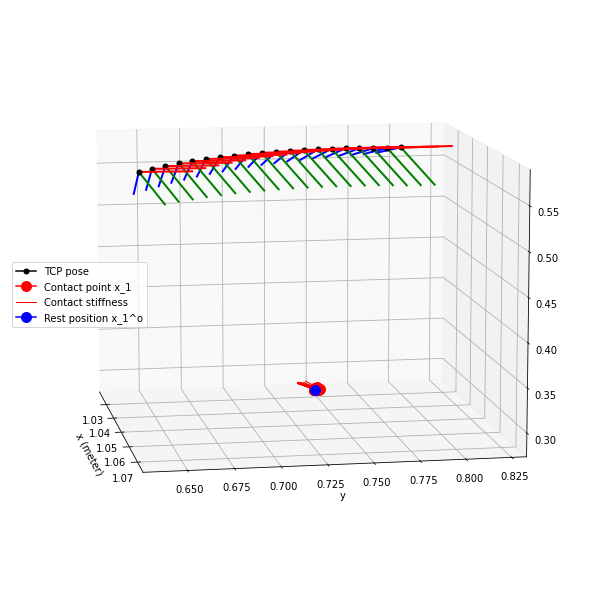

In [64]:
# Plotting the positoin and orientation of the robot and the estimated contact point
import pickle
#%matplotlib
traj = 'data/racer_rotate_long_4.pkl'
#traj = 'data/racer_rotate_and_slip_long_1.pkl'

rest_pos = rospy.get_param('contact_1_rest', [0.0, 0.0, 0.0]) 
stiff = rospy.get_param('contact_1_stiff', [0.0, 0.0, 0.0]) 
scale = 0.03
scales = 3e-6

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(projection="3d")
with open(traj, 'rb') as f:
    _, _, x_is, x_ees = pickle.load(f)

num_pts = x_is.shape[1]
pos_last = x_ees[0][0]
min_dist = 0.008
for xi, xee in zip(x_is.T, x_ees):
    p = np.array(xee[0]).flatten()
    
    o = np.array(xee[1])
    if np.linalg.norm(p[:3] - pos_last[:3]) < min_dist:
        continue
    else:
        pos_last = p
    x = np.array(o[0,:])
    y = np.array(o[1,:])
    z = np.array(o[2,:])
    xs = o@stiff
    ax.plot([p[0], p[0]+scale*x[0]],
            [p[1], p[1]+scale*x[1]],
            [p[2], p[2]+scale*x[2]],
            'r', linewidth=2)
    ax.plot([p[0], p[0]+scale*y[0]],
            [p[1], p[1]+scale*y[1]],
            [p[2], p[2]+scale*y[2]],
            'g', linewidth=2)
    ax.plot([p[0], p[0]+scale*z[0]],
            [p[1], p[1]+scale*z[1]],
            [p[2], p[2]+scale*z[2]],
            'b', linewidth=2)
    
    h_cs = ax.plot([xi[0], xi[0]-scales*xs[0]],
            [xi[1], xi[1]-scales*xs[1]],
            [xi[2], xi[2]-scales*xs[2]],
            'r', linewidth=1)[0]
    h_ee = ax.plot(p[0], p[1], p[2], c = 'k', marker = 'o', ms = 5, label='TCP')[0]

    h_c1 = ax.plot(xi[0], xi[1], xi[2], c = 'r', marker = 'o', ms = 10, label='Estimated contact')[0]
h_rp1 = ax.plot(rest_pos[0], rest_pos[1], rest_pos[2], c= 'b',  marker = 'o', ms = 10, label='Estimated rest position')[0]
plt.tight_layout()
plt.xlabel('x (meter)')
plt.ylabel('y')
ax.view_init(elev=10., azim=-10.)
plt.legend(handles=[h_ee, h_c1, h_cs, h_rp1],labels=['TCP pose', 'Contact point x_1', 'Contact stiffness', 'Rest position x_1^o'], loc='center left')
plt.subplots_adjust(left=-0.11, right=1.11, bottom=0.0, top=1)
#plt.savefig('offline_long_slip.pdf')
plt.show()